# LSTM
LTSM 140. Coding 1-2K. Full-Gudenas. Max RCI. 

Acc 69%, Prec 72%, Recall 75% F1 73%.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-17 16:25:52.348770
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=2000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_max = None
                    rci_count = 0
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            if rci_max is None or rci_val > rci_max:
                                rci_max = rci_val
                            rci_count += 1
                        cell_line += 1   
                    if rci_count > 0:
                        gene_to_rci[gene_id] = rci_max
                        overall_sum += rci_max
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-17 16:26:19.246812
Load RCI values...
Number of RCI values 13512
Mean RCI value 0.742330935725574
Num RCI: 13512
Example RCI: [('ENSG00000000003', 2.29436), ('ENSG00000000419', 2.1946), ('ENSG00000000457', 0.434284)]
Load genes...
2023-01-17 16:26:20.392479
Load sequence...
2023-01-17 16:26:31.483656
Num IDs: 13675
Example IDs: [('ENSG00000186827', 'ENST00000379236.4'), ('ENSG00000127054', 'ENST00000620829.4'), ('ENSG00000235098', 'ENST00000520296.5'), ('ENSG00000187730', 'ENST00000638411.1')]
Count 10438 ones out of 13675 labels.
Example labels: [0, 0, 1, 0]
Num counts: 13675
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167, 155, 106, 168, 159, 

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop_layer = Dropout(0.5) # this model will rely on specific time points not patterns
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-17 16:26:31.515417
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1997, 4)           1028      
                                                                 
 bidirectional (Bidirectiona  (None, 1997, 64)         9472      
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 1997, 16)         1040      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 31952)             0         
                                                                 
 dropout (Dropout)           (None, 31952)             0         
                                                                 
 dense_1 (Dense)     

## Training

In [10]:
def define_middle(genes):
    values = []
    for gene in genes:
        values.append(gene_to_rci[gene])
    mean = np.mean(values)
    stdev = np.std(values)
    print('The middle ground is',mean,'+/-',stdev)
    return mean,stdev
def remove_middle(genes,mean,stdev):
    reduced = []
    for gene in genes:
        rci = gene_to_rci[gene]
        if rci >= mean+stdev or rci <= mean-stdev:
            reduced.append(gene)
    return reduced

In [11]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            obs_mean,obs_std = define_middle(train_genes)
            train_genes = remove_middle(train_genes,obs_mean,obs_std)
            valid_genes = remove_middle(valid_genes,obs_mean,obs_std)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-17 16:26:34.744893
2023-01-17 16:26:34.745101
splitting
Fold 1
The middle ground is 0.7366734387606624 +/- 1.3924513744958174
Training example
[169 161 129 ...   0   0   0]
Train sizes (3140, 1997) (3140, 1)
Valid sizes (779, 1997) (779, 1)
Train set ones/size 1795 / 3140
Valid set ones/size 443 / 779
BUILD MODEL
COMPILE
FIT
2023-01-17 16:26:36.570078
Epoch 1/3
99/99 [==============================] - 20s 121ms/step - loss: 0.6509 - accuracy: 0.6188 - val_loss: 0.6241 - val_accuracy: 0.6650
Epoch 2/3
99/99 [==============================] - 11s 112ms/step - loss: 0.5706 - accuracy: 0.7022 - val_loss: 0.5786 - val_accuracy: 0.6932
Epoch 3/3
99/99 [==============================] - 11s 112ms/step - loss: 0.5329 - accuracy: 0.7287 - val_loss: 0.5878 - val_accuracy: 0.6919


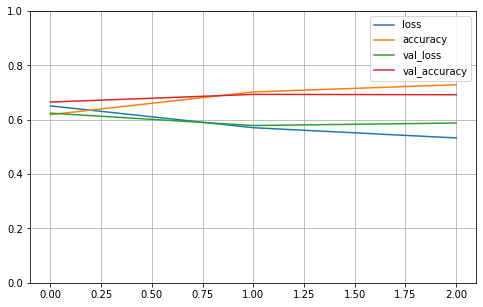

Compute valiation accuracy
2023-01-17 16:27:19.545654
Range of scores: 0.028009135 to 0.9940838
Predicted zeros and ones 346 433
Accuracy: 69.19% Precision: 73.44% Recall: 71.78% F1: 72.60%
2023-01-17 16:27:21.528825
Fold 2
The middle ground is 0.7473853916347489 +/- 1.3880867992674986
Training example
[169 161 129 ...   0   0   0]
Train sizes (3112, 1997) (3112, 1)
Valid sizes (803, 1997) (803, 1)
Train set ones/size 1732 / 3112
Valid set ones/size 478 / 803
BUILD MODEL
COMPILE
FIT
2023-01-17 16:27:24.535194
Epoch 1/3
98/98 [==============================] - 15s 121ms/step - loss: 0.6590 - accuracy: 0.6096 - val_loss: 0.6066 - val_accuracy: 0.6974
Epoch 2/3
98/98 [==============================] - 11s 114ms/step - loss: 0.5681 - accuracy: 0.7134 - val_loss: 0.5552 - val_accuracy: 0.6986
Epoch 3/3
98/98 [==============================] - 11s 114ms/step - loss: 0.5230 - accuracy: 0.7420 - val_loss: 0.5598 - val_accuracy: 0.7123


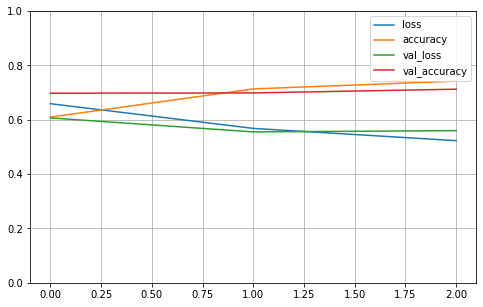

Compute valiation accuracy
2023-01-17 16:28:01.871204
Range of scores: 0.020570168 to 0.9833476
Predicted zeros and ones 352 451
Accuracy: 71.23% Precision: 77.38% Recall: 73.01% F1: 75.13%
2023-01-17 16:28:04.111297
Fold 3
The middle ground is 0.7496265335609622 +/- 1.3927724908522752
Training example
[169 161 129 ...   0   0   0]
Train sizes (3094, 1997) (3094, 1)
Valid sizes (795, 1997) (795, 1)
Train set ones/size 1779 / 3094
Valid set ones/size 411 / 795
BUILD MODEL
COMPILE
FIT
2023-01-17 16:28:05.880453
Epoch 1/3
97/97 [==============================] - 15s 122ms/step - loss: 0.6458 - accuracy: 0.6138 - val_loss: 0.6359 - val_accuracy: 0.6226
Epoch 2/3
97/97 [==============================] - 11s 113ms/step - loss: 0.5693 - accuracy: 0.7088 - val_loss: 0.6102 - val_accuracy: 0.6579
Epoch 3/3
97/97 [==============================] - 11s 114ms/step - loss: 0.5268 - accuracy: 0.7340 - val_loss: 0.6080 - val_accuracy: 0.6918


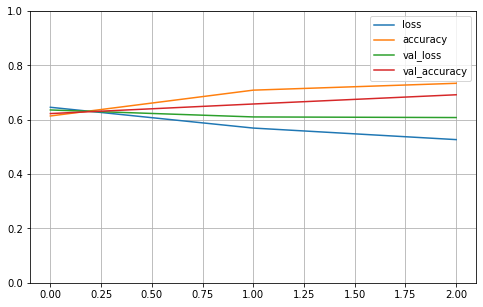

Compute valiation accuracy
2023-01-17 16:28:42.847256
Range of scores: 0.012641735 to 0.9873132
Predicted zeros and ones 359 436
Accuracy: 69.18% Precision: 69.04% Recall: 73.24% F1: 71.07%
2023-01-17 16:28:44.770427
Fold 4
The middle ground is 0.7394206143713228 +/- 1.399554887299058
Training example
[169 161 129 ...   0   0   0]
Train sizes (3105, 1997) (3105, 1)
Valid sizes (762, 1997) (762, 1)
Train set ones/size 1744 / 3105
Valid set ones/size 452 / 762
BUILD MODEL
COMPILE
FIT
2023-01-17 16:28:46.606100
Epoch 1/3
98/98 [==============================] - 15s 121ms/step - loss: 0.6446 - accuracy: 0.6261 - val_loss: 0.5873 - val_accuracy: 0.6864
Epoch 2/3
98/98 [==============================] - 11s 114ms/step - loss: 0.5656 - accuracy: 0.7140 - val_loss: 0.5844 - val_accuracy: 0.6772
Epoch 3/3
98/98 [==============================] - 11s 114ms/step - loss: 0.5408 - accuracy: 0.7275 - val_loss: 0.5802 - val_accuracy: 0.6811


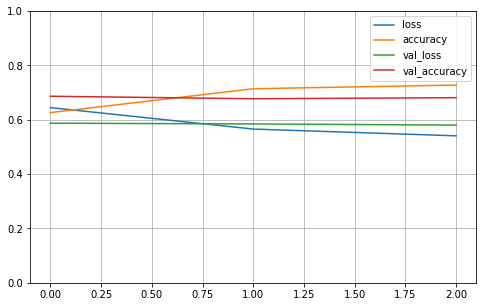

Compute valiation accuracy
2023-01-17 16:29:24.398787
Range of scores: 0.056754142 to 0.9899144
Predicted zeros and ones 271 491
Accuracy: 68.11% Precision: 71.28% Recall: 77.43% F1: 74.23%
2023-01-17 16:29:26.355586
Fold 5
The middle ground is 0.7385486445147086 +/- 1.3869730153111013
Training example
[119 218 102 ...   0   0   0]
Train sizes (3181, 1997) (3181, 1)
Valid sizes (768, 1997) (768, 1)
Train set ones/size 1823 / 3181
Valid set ones/size 429 / 768
BUILD MODEL
COMPILE
FIT
2023-01-17 16:29:28.108592
Epoch 1/3
100/100 [==============================] - 15s 122ms/step - loss: 0.6585 - accuracy: 0.5872 - val_loss: 0.5865 - val_accuracy: 0.6953
Epoch 2/3
100/100 [==============================] - 11s 113ms/step - loss: 0.5687 - accuracy: 0.7067 - val_loss: 0.5881 - val_accuracy: 0.6875
Epoch 3/3
100/100 [==============================] - 11s 113ms/step - loss: 0.5207 - accuracy: 0.7441 - val_loss: 0.6166 - val_accuracy: 0.6849


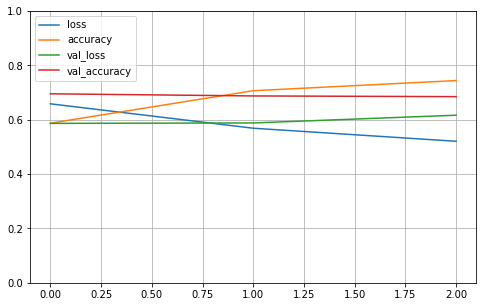

Compute valiation accuracy
2023-01-17 16:30:05.981396
Range of scores: 0.0064160023 to 0.9990816
Predicted zeros and ones 277 491
Accuracy: 68.49% Precision: 69.04% Recall: 79.02% F1: 73.70%
2023-01-17 16:30:07.937615

Cross validation 5 folds 3 epochs
 accuracy mean 69.24% +/- 1.08
 precision mean 72.04% +/- 3.13
 recall mean 74.90% +/- 2.81
 F1 mean 73.35% +/- 1.40
2023-01-17 16:30:07.938953


In [12]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())